## 5. 토픽 모델링(Topic Modeling) - 20뉴스그룹

    문서 집합에 숨겨진 주제를 효과적으로 표현할 수 있는 중심 단어를 함축적으로 추출
    LSA(Latent Semantic Analysis), LDA(Latent Dirichlet Allocation) 등의 분석방법 활용

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# fetch_20newsgroups 에서 8개의 주제만 호출
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x', 
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']

# 위에서 cats변수로 기재된 카테고리만 추출. fetch_20newsgroups()의 categories에 cats입력
news_df = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories=cats, random_state=0)


# LDA는 Count기반 벡터화만 적용가능
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))
feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

# 7862개의 문서가 1000개의 피처로 구성된 행렬데이터

CountVectorizer Shape: (7862, 1000)


In [2]:
lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [3]:
# components_ 속성은 개별 토픽별로 각 word 피처가 얼마나 많이 그 토픽에 할당됐는지에 대한 수치를 가짐
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

In [4]:
# 각 토픽별 word 연관도를 보기 쉽게 만드는 함수
def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)     
        
        # components_array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array 인덱스를 반환
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes = topic_word_indexes[:no_top_words]       
        
        # top_indexes 대상인 인덱스별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)
        
# CountVectorizer 객체 내의 전체 word의 명칭을 get_features_names()를 통해 추출
feature_names = count_vect.get_feature_names()

# 토픽별 가장 연관도가 높은 word를 15개만 추출
display_topics(lda, feature_names, 15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run


## 6. 문서 군집화 소개와 실습(Opinion Review 데이터 세트)
    동일한 군집에 속하는 문서를 같은 카테고리 소속으로 분류하는 비지도학습

#### 6.1 문서 군집화 수행

In [5]:
import pandas as pd
import glob, os

path = r'C:\Users\NK\Desktop\programming\python\CUAI\파이썬 머신러닝 완벽가이드\OpinosisDataset1.0\topics'
# path로 지정한 디렉터리 밑에 있는 모든 .data파일의 파일명을 리스트로 취합.
all_files = glob.glob(os.path.join(path, '*.data'))
filename_list = []
opinion_text = []

# 개별 파일의 파일명은 filename_list로 취합
# 개별 파일의 파일 내용은 dfm 로딩 후 다시 string으로 변환해 opinion_text list로 취합
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    
    # 절대 경로로 주어진 파일명을 가공. 리눅스에서 수행할 때는 \\를 /로 변경
    # 맨 마지막 .data확장자도 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    
    # 파일명 list와 파일 내용 list에 파일명과 파일 내용을 추가.
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
# 파일명 list와 파일 내용 list 객체를 dfm으로 생성
document_df = pd.DataFrame({'filename' : filename_list, 'opinion_text' : opinion_text})
print(document_df.shape)
document_df.head()

(51, 2)


,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,...
1,bathroom_bestwestern_hotel_sfo,...
2,battery-life_amazon_kindle,...
3,battery-life_ipod_nano_8gb,...
4,battery-life_netbook_1005ha,...


In [6]:
# 문서 토큰화 함수정의

from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer = LemNormalize, stop_words = 'english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
# opinion_text 칼럼에 대해 피처 벡터화 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

C:\Users\NK\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [8]:
# K-평균 군집화 수행

from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [9]:
# 각 데이터별로 할당된 군집의 레이블을 documnet_df의 칼럼으로 추가
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
1,bathroom_bestwestern_hotel_sfo,...,1
2,battery-life_amazon_kindle,...,3
3,battery-life_ipod_nano_8gb,...,3
4,battery-life_netbook_1005ha,...,3


In [10]:
# cluster_label이 0인 파일 출력
# sort_values(by='정렬칼럼명') 메쏘드로 데이터 정렬
document_df[document_df['cluster_label']==0].sort_values(by='filename')

# 주로 차량용 네비게이션

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
8,directions_garmin_nuvi_255W_gps,...,0
9,display_garmin_nuvi_255W_gps,...,0
33,satellite_garmin_nuvi_255W_gps,...,0
34,screen_garmin_nuvi_255W_gps,...,0
43,speed_garmin_nuvi_255W_gps,...,0
47,transmission_toyota_camry_2007,...,0
48,updates_garmin_nuvi_255W_gps,...,0


In [11]:
# cluster_label이 1인 파일 출력
document_df[document_df['cluster_label']==1].sort_values(by='filename')

# 주로 호텔

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,...,1
13,food_holiday_inn_london,...,1
14,food_swissotel_chicago,...,1
15,free_bestwestern_hotel_sfo,...,1
20,location_bestwestern_hotel_sfo,...,1
21,location_holiday_inn_london,...,1
24,parking_bestwestern_hotel_sfo,...,1
28,price_holiday_inn_london,...,1
32,room_holiday_inn_london,...,1
30,rooms_bestwestern_hotel_sfo,...,1


In [12]:
# cluster_label이 2인 파일 출력
document_df[document_df['cluster_label']==2].sort_values(by='filename')

# 자동차

,filename,opinion_text,cluster_label
6,comfort_honda_accord_2008,...,2
7,comfort_toyota_camry_2007,...,2
16,gas_mileage_toyota_camry_2007,...,2
17,interior_honda_accord_2008,...,2
18,interior_toyota_camry_2007,...,2
22,mileage_honda_accord_2008,...,2
25,performance_honda_accord_2008,...,2
29,quality_toyota_camry_2007,...,2
37,seats_honda_accord_2008,...,2


In [13]:
# cluster_label이 3인 파일 출력
document_df[document_df['cluster_label']==3].sort_values(by='filename')

# 아이팟, 넷북

,filename,opinion_text,cluster_label
2,battery-life_amazon_kindle,...,3
3,battery-life_ipod_nano_8gb,...,3
4,battery-life_netbook_1005ha,...,3
26,performance_netbook_1005ha,...,3
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,3
49,video_ipod_nano_8gb,...,3


In [14]:
# cluster_label이 4인 파일 출력
document_df[document_df['cluster_label']==4].sort_values(by='filename')

# 전자제품

,filename,opinion_text,cluster_label
5,buttons_amazon_kindle,...,4
10,eyesight-issues_amazon_kindle,...,4
11,features_windows7,...,4
12,fonts_amazon_kindle,...,4
19,keyboard_netbook_1005ha,...,4
23,navigation_amazon_kindle,...,4
27,price_amazon_kindle,...,4
35,screen_ipod_nano_8gb,...,4
36,screen_netbook_1005ha,...,4
41,size_asus_netbook_1005ha,...,4


In [15]:
# 위에서는 centroid를 5개로 설정했기 때문에 다소 세분화된 군집화 경향 존재
# centroid를 3개로 설정했을 때 군집화

from sklearn.cluster import KMeans

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
1,bathroom_bestwestern_hotel_sfo,...,1
2,battery-life_amazon_kindle,...,0
3,battery-life_ipod_nano_8gb,...,0
4,battery-life_netbook_1005ha,...,0


In [16]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

# cluster_label==0 은 전자제품

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
2,battery-life_amazon_kindle,...,0
3,battery-life_ipod_nano_8gb,...,0
4,battery-life_netbook_1005ha,...,0
5,buttons_amazon_kindle,...,0
8,directions_garmin_nuvi_255W_gps,...,0
9,display_garmin_nuvi_255W_gps,...,0
10,eyesight-issues_amazon_kindle,...,0
11,features_windows7,...,0
12,fonts_amazon_kindle,...,0


In [17]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

# cluster_label==1 은 호텔

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,...,1
13,food_holiday_inn_london,...,1
14,food_swissotel_chicago,...,1
15,free_bestwestern_hotel_sfo,...,1
20,location_bestwestern_hotel_sfo,...,1
21,location_holiday_inn_london,...,1
24,parking_bestwestern_hotel_sfo,...,1
28,price_holiday_inn_london,...,1
32,room_holiday_inn_london,...,1
30,rooms_bestwestern_hotel_sfo,...,1


In [18]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

# cluster_label==2 는 자동차

,filename,opinion_text,cluster_label
6,comfort_honda_accord_2008,...,2
7,comfort_toyota_camry_2007,...,2
16,gas_mileage_toyota_camry_2007,...,2
17,interior_honda_accord_2008,...,2
18,interior_toyota_camry_2007,...,2
22,mileage_honda_accord_2008,...,2
25,performance_honda_accord_2008,...,2
29,quality_toyota_camry_2007,...,2
37,seats_honda_accord_2008,...,2
47,transmission_toyota_camry_2007,...,2


#### 6.2 군집별 핵심 단어 추출

In [19]:
# KMeans 군집화 결과 centroid에서 가까울 수록 군집화의 핵심단어로 추정
# KMeans의 clusters_centers 속성 : 군집의 중심을 기준으로 얼마나 가깝게 위치해 있는지 반환
#  -> 배열 값으로 제공되는데, 행은 개별 군집을, 열은 개별 피처를 의미
#  -> (1,1)의 의미 : 첫번째 피쳐(단어)는 첫번째 군집에 0.01005322 만큼 가깝다
#  -> 해당값은 0~1사이, 1에 가까울수록 중심과 가까움을 의미
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]]


In [20]:
# 군집별 top n개의 핵심단어, 그 단어의 중심위치 상댓값, 대상 파일명을 반환하는 함수
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details={}
    
    # cluster_centers array의 값이 큰 순으로 정렬된 인덱스 값을 반환
    # centroid별 할당된 word피처들의 거리값이 큰 순으로 값을 구하기 위함
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 군집별로 반복하면서 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1]로 구한 인덱스를 이용해 top n 피처 단어를 구함
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [feature_names[ind] for ind in top_feature_indexes]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심단어와 중심위치 상댓값, 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details

In [21]:
# get_cluster_details() 함수가 가진 
# 개별 군집번호, 핵심단어, 핵심단어 중심위치 상댓값, 파일명 속성값을 보기 좋게 표현하기 위한 함수 정의

def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print(f'####### Cluster {cluster_num}')
        print('Top features : ', cluster_detail['top_features'])
        print('Reviews 파일명 : ', cluster_detail['filenames'][:7])
        print('=================================================')

In [22]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model = km_cluster, cluster_data = document_df,
                                      feature_names = feature_names, clusters_num=3, top_n_features=10)
print_cluster_details(cluster_details)

####### Cluster 0
Top features :  ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 :  ['accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'battery-life_ipod_nano_8gb', 'battery-life_netbook_1005ha', 'buttons_amazon_kindle', 'directions_garmin_nuvi_255W_gps', 'display_garmin_nuvi_255W_gps']
####### Cluster 1
Top features :  ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 :  ['bathroom_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'food_swissotel_chicago', 'free_bestwestern_hotel_sfo', 'location_bestwestern_hotel_sfo', 'location_holiday_inn_london', 'parking_bestwestern_hotel_sfo']
####### Cluster 2
Top features :  ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 :  ['comfort_honda_accord_2008', 'comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'int

## 7. 문서 유사도
    문서 간의 벡터값을 구하고 벡터 사이의 사잇각을 구해서 문서가 서로 얼마나 유사한지 수치로 표시

#### 7.1 코사인 유사도

In [23]:
# 두개의 넘파이 배열에 대한 코사인 유사도를 구하는 함수
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm
    
    return similarity

In [24]:
# 문서 유사도를 비교하기 위해 3개의 문서를 RF-IDF 로 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [25]:
# 희소행렬 tfidf_vect_simple을 밀집 행렬로 변환
feature_vect_dense = feature_vect_simple.todense()

# 각 문장의 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)

In [26]:
# 첫번째 문장과 두번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1, vect2)
print(f'문장1, 문장2 Cosine 유사도: {similarity_simple:.3f}')

# 첫번째 문장과 세번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1, vect3)
print(f'문장1, 문장3 Cosine 유사도: {similarity_simple:.3f}')

# 두번째 문장과 세번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect2, vect3)
print(f'문장2, 문장3 Cosine 유사도: {similarity_simple:.3f}')

문장1, 문장2 Cosine 유사도: 0.402
문장1, 문장3 Cosine 유사도: 0.404
문장2, 문장3 Cosine 유사도: 0.456


In [27]:
# 사이킷런이 제공하는 코사인 유사도 API
# 기준이 되는 문서와 비교할 문서 두가지를 입력파라미터로 받아 코사인 유사도 측정
# 파라미터로 희소행렬 / 밀집행렬, 행렬 / 배열 모두 가능해서 별도의 변환 작업 필요 x 

from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)


# 본인자신과의 비교 삭제
similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]
[[0.40207758 0.40425045]]


In [28]:
# 모든 행렬에 대해 모든 코사인 유사도 구하기
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


#### 7.2 Opinion Review 데이터 세트를 이용한 문서 유사도 측정

In [29]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'C:\Users\NK\Desktop\programming\python\CUAI\파이썬 머신러닝 완벽가이드\OpinosisDataset1.0\topics'
# path로 지정한 디렉터리 밑에 있는 모든 .data파일의 파일명을 리스트로 취합.
all_files = glob.glob(os.path.join(path, '*.data'))
filename_list = []
opinion_text = []

# 개별 파일의 파일명은 filename_list로 취합
# 개별 파일의 파일 내용은 dfm 로딩 후 다시 string으로 변환해 opinion_text list로 취합
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    
    # 절대 경로로 주어진 파일명을 가공. 리눅스에서 수행할 때는 \\를 /로 변경
    # 맨 마지막 .data확장자도 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    
    # 파일명 list와 파일 내용 list에 파일명과 파일 내용을 추가.
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
# 파일명 list와 파일 내용 list 객체를 dfm으로 생성
document_df = pd.DataFrame({'filename' : filename_list, 'opinion_text' : opinion_text})

# TF-IDF로 피처벡터화
tfidf_vect = TfidfVectorizer(tokenizer = LemNormalize, stop_words='english',\
                            ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

# 문서 군집화
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

C:\Users\NK\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1 인 데이터는 호텔로 군집화된 데이터. dfm에서 해당 인덱스를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 군집화 된 문서들의 dfm Index : ', hotel_indexes)

# 호텔로 군집화된 데이터 중 첫번째 문서를 추출해 파일명 표시
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명', comparison_docname, '와 타 문서 유사도 #####')

# document_df에서 추출한 Index 객체를 feature_vect로 입력해 호텔 군집화된 feature_vect 추출
# 이를 이용해 호텔로 군집화된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정

similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화 된 문서들의 dfm Index :  Int64Index([1, 13, 14, 15, 20, 21, 24, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')
##### 비교 기준 문서명 bathroom_bestwestern_hotel_sfo 와 타 문서 유사도 #####
[[1.         0.0430688  0.05221059 0.06189595 0.05846178 0.06193118
  0.03638665 0.11742762 0.38038865 0.32619948 0.51442299 0.11282857
  0.13989623 0.1386783  0.09518068 0.07049362]]


Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

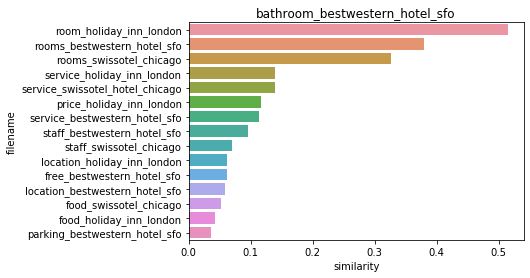

In [31]:
# 첫번째 문서와 각 문서들간의 유사도 시각화

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 첫 번째 문서와 타문서간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:,1:]

# 유사도가 큰 순으로 hotel_indexes를 추출해 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(data = hotel_1_sim_df, x='similarity', y='filename')
plt.title(comparison_docname)

## 8. 한글 텍스트 처리 - KoNLPy를 이용한 네이버 영화 평점 감성분석

In [32]:
import pandas as pd

train_df = pd.read_csv('nsmc/ratings_train.txt', sep='\t')
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [33]:
train_df['label'].value_counts()
# 학습데이터 label의 1은 긍정, 0은 부정

0    75173
1    74827
Name: label, dtype: int64

In [34]:
import re

# 리뷰가 없는 인덱스는 공백처리
train_df = train_df.fillna(' ')
# 정규표현식을 이용해 숫자를 공백으로 변경
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r'\d+', ' ', x))

# 테스트 데이터 세트를 로딩하고 동일하게 NULL 및 숫자를 공백으로 전환
test_df = pd.read_csv('nsmc/ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x : re.sub(r'\d+', ' ', x))

# id 칼럼 삭제 수행
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [35]:
# 트위터 클래스를 이용하여 한글 형태소 분석
from konlpy.tag import Twitter

twitter=Twitter()

# 입력인자로 들어온 문장을 형태소 단어 형태로 바꿔주는 함수 정의
def tw_tokenizer(text):
    # 입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환
    tokens_ko = twitter.morphs(text)
    return tokens_ko

C:\Users\NK\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs() 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

In [38]:
# 로지스틱 회귀를 이용 분류기반의 감성분석 수행
lg_clf = LogisticRegression(random_state=0)

# 파라미터 C 최적화를 위해 GridSearchCV를 이용
params = {'C' : [1, 3.5, 4.5, 5.5, 10]}
grid_cv = GridSearchCV(lg_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_,4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\NK\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\NK\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

{'C': 3.5} 0.8592


C:\Users\NK\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [39]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)
print('Logistic Regression 정확도 : ', accuracy_score(test_df['label'], preds))

Logistic Regression 정확도 :  0.86186
